# Overall for
Attention-based TimeGAN

In [74]:
"""
This script implements the TimeGAN model for time-series data generation. The model consists of four main components: an encoder, a generator, a discriminator, and a recovery network.
The encoder and generator work together to transform real time-series data into a latent space, and then back into the data space. 
The discriminator is trained to distinguish between real and generated time-series data, while the recovery network is trained to reconstruct the original data from the latent representation.
"""

'\nThis script implements the TimeGAN model for time-series data generation. The model consists of four main components: an encoder, a generator, a discriminator, and a recovery network.\nThe encoder and generator work together to transform real time-series data into a latent space, and then back into the data space. \nThe discriminator is trained to distinguish between real and generated time-series data, while the recovery network is trained to reconstruct the original data from the latent representation.\n'

In [75]:
!conda install -c conda-forge google-colab

/bin/bash: conda: command not found


In [76]:
# !pip install --upgrade jupyter ipywidgets

In [77]:
# !pip install --upgrade tensorflow matplotlib tqdm keras

In [78]:
# from google.colab import output
# output.enable_custom_widget_manager()

In [79]:
# from google.colab import output
# output.disable_custom_widget_manager()

In [80]:
import os
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'True'
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

In [81]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [82]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    
device = '/device:GPU:0' if tf.test.is_gpu_available() else '/device:CPU:0'

Default GPU Device: /device:GPU:0


In [83]:
print(device)

/device:GPU:0


# Data generation

In [84]:
def MinMaxScaler(data):
  """Min Max normalizer.
  Args:
    - data: original data
  Returns:
    - norm_data: normalized data"""
  
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  norm_data = numerator / (denominator + 1e-7)
  
  return norm_data

## Sine data

In [85]:
def generate_sine_data(num_samples, sequence_length, feature_dim):
    """Generates sine wave data.
    Args:
        num_samples (int): The number of samples to generate.
        sequence_length (int): The length of each time-series sample.
        feature_dim (int): The number of features for each sample.
    Returns:
        list: The generated sine wave data."""

    data = []

    for _ in range(num_samples):      
        temp = []
        for _ in range(feature_dim):
            freq, phase = np.random.uniform(0.25, 0.35, 2)
            temp_data = [np.sin(freq * j + phase) for j in range(sequence_length)]
            temp.append(temp_data)

        temp = np.transpose(temp)

        # Normalize to [0, 1]
        temp = (temp - np.min(temp)) / (np.max(temp) - np.min(temp))

        data.append(temp)
        
    return data

In [86]:
def plot_sine_data(data):
    """Plots the generated sine wave data.
    Args:
        data (list): The generated sine wave data."""

    # Create a new figure
    plt.figure(figsize=(10, 6))

    samples_to_plot = data[:10]
    # Plot each sample
    for i, sample in enumerate(samples_to_plot):
        plt.plot(sample, label=f'Sample {i+1}')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

## Stock data

In [87]:
def real_data_loading(data_name, seq_len, num_samples=4096, feature_dim=1):
  """Load and preprocess datasets.
  
  Args:
    - data_name: sine, stock, or energy
    - seq_len: sequence length
    - num_samples: number of samples for sine data
    - feature_dim: feature dimension for sine data
    
  Returns:
    - data: preprocessed data.
  """  
  assert data_name in ['sine', 'stock', 'energy']
  
  if data_name == 'stock':
    ori_data = np.loadtxt('data/stock_data.csv', delimiter = ",",skiprows = 1)
  elif data_name == 'energy':
    ori_data = np.loadtxt('data/energy_data.csv', delimiter = ",",skiprows = 1)
  elif data_name == 'sine':
    ori_data = generate_sine_data(num_samples, seq_len, feature_dim)
    plot_sine_data(ori_data)
    return ori_data
  
  # Normalize the data
  ori_data = MinMaxScaler(ori_data)
  
  # Preprocess the dataset
  temp_data = [] 
  # Cut data by sequence length
  for i in range(0, len(ori_data) - seq_len):
    _x = ori_data[i:i + seq_len]
    temp_data.append(_x)
  
  # Mix the datasets (to make it similar to i.i.d)
  idx = np.random.permutation(len(temp_data))
  data = []
  for i in range(len(temp_data)):
    data.append(temp_data[idx[i]])
  
  return data

# Model Class

## Attention

In [88]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    dk = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

In [89]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = layers.Dense(d_model)
        self.wk = layers.Dense(d_model)
        self.wv = layers.Dense(d_model)

        self.dense = layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

In [90]:
class SelfAttentionWrapper(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(SelfAttentionWrapper, self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)

    def call(self, inputs, mask=None):
        output, _ = self.multi_head_attention(inputs, inputs, inputs, mask)
        return output

## Nets for GAN

In [91]:
class TimeGANGenerator(tf.keras.Model):
    def __init__(self, hidden_dim, seq_len, n_features, num_heads, dropout_rate=0.1):
        super(TimeGANGenerator, self).__init__()
        self.lstm = layers.RNN(layers.LSTMCell(hidden_dim), return_sequences=True, unroll=True) 
        self.dropout = layers.Dropout(dropout_rate)
        self.attention = SelfAttentionWrapper(d_model=hidden_dim, num_heads=num_heads)
        self.dense = layers.Dense(n_features)

    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dropout(x)
        x = self.attention(x)
        x = self.dense(x)
        return x

In [92]:
class TimeGANDiscriminator(tf.keras.Model):
    def __init__(self, hidden_dim, seq_len, n_features, dropout_rate=0.1):
        super(TimeGANDiscriminator, self).__init__()
        self.lstm = layers.RNN(layers.LSTMCell(hidden_dim), return_sequences=True, unroll=True) 
        self.dropout = layers.Dropout(dropout_rate)
        self.dense1 = layers.Dense(hidden_dim)
        self.layer_norm = layers.LayerNormalization()
        self.dense2 = layers.Dense(1, activation='sigmoid') 

    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.layer_norm(x)
        x = self.dense2(x) # The output layer to produce the final output
        return x

In [93]:
class TimeGANEcoder(tf.keras.Model):
    def __init__(self, hidden_dim, num_heads, seq_len, n_features, dropout_rate=0.1):
        super(TimeGANEcoder, self).__init__()
        self.self_attention = SelfAttentionWrapper(hidden_dim, num_heads)
        self.lstm1 = layers.RNN(layers.LSTMCell(hidden_dim), return_sequences=True, unroll=True) 
        self.lstm2 = layers.RNN(layers.LSTMCell(hidden_dim), return_sequences=True, unroll=True)
        self.dropout = layers.Dropout(dropout_rate)
        self.dense1 = layers.Dense(hidden_dim)
        self.layer_norm = layers.LayerNormalization()
        self.dense2 = layers.Dense(n_features)

    def call(self, inputs):
        x = self.self_attention(inputs)
        x = self.lstm1(x)
        x = self.dropout(x)
        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.layer_norm(x)
        return x

In [94]:
class TimeGANRecovery(tf.keras.Model):
    def __init__(self, hidden_dim, num_heads, seq_len, n_features, dropout_rate=0.1):
        super(TimeGANRecovery, self).__init__()
        self.self_attention = SelfAttentionWrapper(hidden_dim, num_heads)
        self.lstm1 = layers.RNN(layers.LSTMCell(hidden_dim), return_sequences=True, unroll=True) 
        self.lstm2 = layers.RNN(layers.LSTMCell(hidden_dim), return_sequences=True, unroll=True)
        self.dropout = layers.Dropout(dropout_rate)
        self.dense1 = layers.Dense(hidden_dim)
        self.layer_norm = layers.LayerNormalization()
        self.dense2 = layers.Dense(n_features)

    def call(self, inputs):
        x = self.self_attention(inputs)
        x = self.lstm1(x)
        x = self.dropout(x)
        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.layer_norm(x)
        x = self.dense2(x) # The output layer to produce the final output
        return x

## Main GAN class

In [95]:
class TimeGAN(tf.keras.Model):
    """
    The TimeGAN model for time-series data generation.
    This model consists of four main components: an encoder, a generator, a discriminator, and a recovery network.
    The encoder and generator work together to transform real time-series data into a latent space, and then back into the data space. 
    The discriminator is trained to distinguish between real and generated time-series data, while the recovery network is trained to reconstruct the original data from the latent representation.
    """
    def __init__(self, seq_len, n_features, hidden_dim, num_heads, batch_size):
        super(TimeGAN, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.batch_size = batch_size

        self.prev_loss = None
        self.disc_loss_threshold = 0.0010

        self.train_gen_enc_rec_losses = []
        self.val_gen_enc_rec_losses = []
        self.train_disc_losses = []
        self.val_disc_losses = []
        
        self.generator = TimeGANGenerator(hidden_dim,  seq_len, n_features, num_heads, dropout_rate=0.1)
        self.discriminator = TimeGANDiscriminator(hidden_dim, seq_len, n_features, dropout_rate=0.1)
        self.encoder = TimeGANEcoder(hidden_dim, num_heads, seq_len, n_features, dropout_rate=0.1)
        self.recovery = TimeGANRecovery(hidden_dim, num_heads, seq_len, n_features, dropout_rate=0.1)

    def compile(self, optimizer, wasserstein_loss, gradient_penalty_weight):
        super(TimeGAN, self).compile()
        self.optimizer = optimizer
        self.wasserstein_loss = wasserstein_loss
        self.gradient_penalty_weight = gradient_penalty_weight

    def gradient_penalty(self, real_data, fake_data):
        """
        Calculates the gradient penalty for the Wasserstein loss.

        This method interpolates between real and generated data, and calculates the gradient of the discriminator's predictions with respect to the interpolated data. 
        The gradient penalty is the squared difference between the norm of these gradients and 1.
        """
        batch_size, seq_len, n_features = real_data.shape
        alpha = tf.random.uniform(shape=[batch_size, 1, 1], minval=0., maxval=1.)
        alpha = tf.broadcast_to(alpha, [batch_size, seq_len, n_features])
        interpolated = alpha * real_data + (1 - alpha) * fake_data
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            d_interpolated = self.discriminator(interpolated)
        gradients = tape.gradient(d_interpolated, [interpolated])[0]
        grad_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
        return tf.reduce_mean(tf.square(grad_norm - 1))

    def train_step(self, real_data, optimizer, disc_steps=5):
        with tf.device(device):
            batch_size = tf.shape(real_data)[0]

            # Train discriminator network with 5 steps in "one" for its better optimization
            for _ in range(disc_steps):
                with tf.GradientTape() as tape_disc:
                    z = tf.random.normal(shape=(batch_size, self.seq_len, self.hidden_dim))
                    e = self.encoder(real_data)
                    fake_data = self.generator(e + z)
                    d_real = self.discriminator(real_data)
                    d_fake = self.discriminator(fake_data)

                    disc_loss = -tf.reduce_mean(d_real) + tf.reduce_mean(d_fake)
                    gp = self.gradient_penalty(real_data, fake_data)
                    disc_loss += self.gradient_penalty_weight * gp

                grads_disc = tape_disc.gradient(disc_loss, self.discriminator.trainable_variables)
                grads_disc = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in grads_disc]  # Gradient Clipping

                if disc_loss <= self.disc_loss_threshold and disc_loss >= 0:
                    break

                optimizer.apply_gradients(zip(grads_disc, self.discriminator.trainable_variables))

            # Train generator, encoder, and recovery networks
            with tf.GradientTape() as tape_gen_enc_rec:
                z = tf.random.normal(shape=(batch_size, self.seq_len, self.hidden_dim))
                e = self.encoder(real_data)
                fake_data = self.generator(e + z)
                d_fake = self.discriminator(fake_data)
                rec_data = self.recovery(e)

                gen_enc_rec_loss = -tf.reduce_mean(d_fake) + self.wasserstein_loss(real_data, rec_data)

            grads_gen_enc_rec = tape_gen_enc_rec.gradient(gen_enc_rec_loss, self.encoder.trainable_variables + self.generator.trainable_variables + self.recovery.trainable_variables)
            grads_gen_enc_rec = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in grads_gen_enc_rec]  # Gradient Clipping
            optimizer.apply_gradients(zip(grads_gen_enc_rec, self.encoder.trainable_variables + self.generator.trainable_variables + self.recovery.trainable_variables))

            # Calculate new loss
            new_loss = {'gen_enc_rec_loss': gen_enc_rec_loss, 'disc_loss': disc_loss}

            # Set new_loss as prev_loss for the next iteration
            self.prev_loss = new_loss

            return new_loss


    def test_step(self, real_data):
          batch_size = tf.shape(real_data)[0]
          z = tf.random.normal(shape=(batch_size, self.seq_len, self.hidden_dim))
          e = self.encoder(real_data)
          fake_data = self.generator(e + z)
          d_fake = self.discriminator(fake_data)
          rec_data = self.recovery(e)

          gen_enc_rec_loss = -tf.reduce_mean(d_fake) + self.wasserstein_loss(real_data, rec_data)
          d_real = self.discriminator(real_data)
          d_fake = self.discriminator(fake_data)

          disc_loss = -tf.reduce_mean(d_real) + tf.reduce_mean(d_fake)
          gp = self.gradient_penalty(real_data, fake_data)
          disc_loss += self.gradient_penalty_weight * gp

          return {'gen_enc_rec_loss': gen_enc_rec_loss, 'disc_loss': disc_loss}
    
    def train(self, train_dataset, val_dataset, epochs, optimizer):
          gen_enc_rec_losses = []
          disc_losses = []
          val_gen_enc_rec_losses = []
          val_disc_losses = []

          # Outer progress bar (for epochs)
          epoch_progress = tqdm(range(epochs), desc="Epochs", position=0, total=epochs)

          # Train
          for epoch in epoch_progress:
              # Determine number of batches in the epoch
              num_batches_train = len(train_dataset)
              num_batches_val = len(val_dataset)

              # Inner progress bar (for batches within an epoch)
              batch_progress_train = tqdm(train_dataset, desc="Train Batch", position=1, total=num_batches_train, leave=False)
              batch_progress_val = tqdm(val_dataset, desc="Val Batch", position=2, total=num_batches_val, leave=False)

                  # Training
              for batch in batch_progress_train:
                  loss = self.train_step(batch, optimizer)
                  gen_enc_rec_losses.append(loss['gen_enc_rec_loss'])
                  disc_losses.append(loss['disc_loss'])

                  # Update batch progress bar
                  batch_progress_train.set_postfix({"gen_enc_rec_loss": f"{loss['gen_enc_rec_loss']:.4f}",
                                                      "disc_loss": f"{loss['disc_loss']:.4f}"})

              # Validation
              for batch in batch_progress_val:
                  val_loss = self.test_step(batch)
                  val_gen_enc_rec_losses.append(val_loss['gen_enc_rec_loss'])
                  val_disc_losses.append(val_loss['disc_loss'])

                  # Update batch progress bar
                  batch_progress_val.set_postfix({"val_gen_enc_rec_loss": f"{val_loss['gen_enc_rec_loss']:.4f}",
                                                  "val_disc_loss": f"{val_loss['disc_loss']:.4f}"})

                  # Compute average losses
                  avg_gen_enc_rec_loss = np.mean(gen_enc_rec_losses[-num_batches_train:])
                  avg_disc_loss = np.mean(disc_losses[-num_batches_train:])
                  avg_val_gen_enc_rec_loss = np.mean(val_gen_enc_rec_losses)
                  avg_val_disc_loss = np.mean(val_disc_losses)

              # Update epoch progress bar
              epoch_progress.set_postfix({"avg_gen_enc_rec_loss": f"{avg_gen_enc_rec_loss:.4f}",
                                          "avg_disc_loss": f"{avg_disc_loss:.4f}",
                                          "avg_val_gen_enc_rec_loss": f"{avg_val_gen_enc_rec_loss:.4f}",
                                          "avg_val_disc_loss": f"{avg_val_disc_loss:.4f}"})
              
              if epoch % 100 == 0:
                  self.plot_generated_data(next(iter(train_dataset)).numpy())

          self.train_gen_enc_rec_losses = gen_enc_rec_losses
          self.val_gen_enc_rec_losses = val_gen_enc_rec_losses
          self.train_disc_losses = disc_losses
          self.val_disc_losses = val_disc_losses

    def test(self, test_dataset):
          test_gen_enc_rec_losses = []
          test_disc_losses = []
          test_progress = tqdm(test_dataset, desc="Testing", position=0, total=len(test_dataset))
          for batch in test_progress:
              test_loss = self.test_step(batch)
              test_gen_enc_rec_losses.append(test_loss['gen_enc_rec_loss'])
              test_disc_losses.append(test_loss['disc_loss'])
              test_progress.set_postfix({"test_gen_enc_rec_loss": f"{test_loss['gen_enc_rec_loss']:.4f}",
                                        "test_disc_loss": f"{test_loss['disc_loss']:.4f}"})
              test_progress.update()

          # Compute average test losses
          avg_test_gen_enc_rec_loss = np.mean(test_gen_enc_rec_losses)
          avg_test_disc_loss = np.mean(test_disc_losses)

          print(f"Test gen_enc_rec_loss: {avg_test_gen_enc_rec_loss:.4f}, Test disc_loss: {avg_test_disc_loss:.4f}")
   
    def plot_losses(self):
          fig, axs = plt.subplots(2, figsize=(12, 12))

          # Plot for generator/encoder/recovery loss
          axs[0].plot(self.train_gen_enc_rec_losses, label='Training Gen/Enc/Rec Loss')
          axs[0].plot(self.val_gen_enc_rec_losses, label='Validation Gen/Enc/Rec Loss')
          axs[0].set_title('Generator/Encoder/Recovery Losses')
          axs[0].set_xlabel('Epoch')
          axs[0].set_ylabel('Loss')
          axs[0].legend()

          # Plot for discriminator loss
          axs[1].plot(self.train_disc_losses, label='Training Disc Loss')
          axs[1].plot(self.val_disc_losses, label='Validation Disc Loss')
          axs[1].set_title('Discriminator Losses')
          axs[1].set_xlabel('Epoch')
          axs[1].set_ylabel('Loss')
          axs[1].legend()

          plt.tight_layout()
          plt.show()

    def plot_generated_data(self, real_data, num_examples=5):
          batch_size = tf.shape(real_data)[0]
          z = tf.random.normal(shape=real_data.shape)
          e = self.encoder(real_data[:1])
          fake_data = self.generator(e + z)
          
          fig, axs = plt.subplots(num_examples, 2)
          for i in range(num_examples):
              axs[i, 0].plot(real_data[i])
              axs[i, 0].set_title('Real Data')
              axs[i, 1].plot(fake_data[i])
              axs[i, 1].set_title('Generated Data')
          plt.show()

# Model initialization

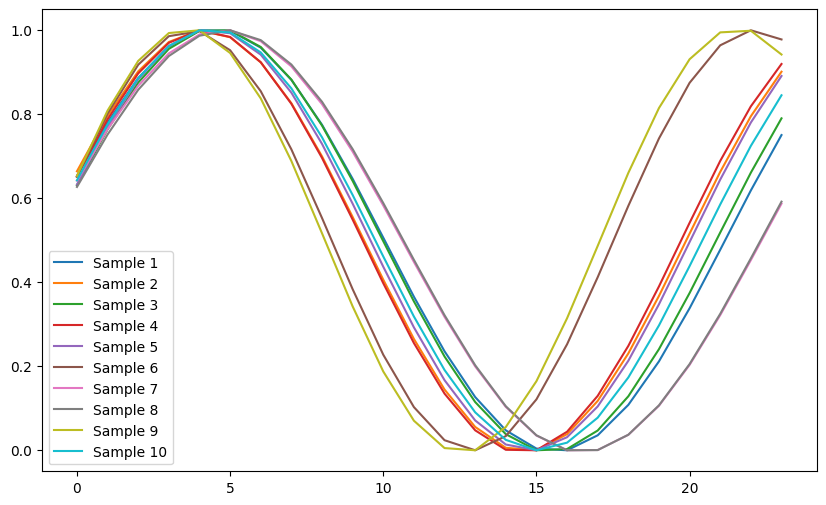

In [96]:
#Data
samples = 4096
seq_len = 24
n_features = 1

#Model
hidden_dim = 24
num_heads = 4
batch_size = 4096

# Generate the data
real_data = real_data_loading(data_name='sine', seq_len=seq_len, num_samples=4096, feature_dim=n_features)

# Plot the data

In [97]:
# getting number of samples
num_samples = samples
num_train_samples = int(num_samples * 0.7)
num_val_samples = int(num_samples * 0.15)
num_test_samples = num_samples - num_train_samples - num_val_samples

# Split the data
train_data = real_data[:num_train_samples]
val_data = real_data[num_train_samples:num_train_samples + num_val_samples]
test_data = real_data[num_train_samples + num_val_samples:]

# Convert to TensorFlow tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float32)
val_data_tensor = tf.convert_to_tensor(val_data, dtype=tf.float32)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float32)

# Create TensorFlow Dataset objects for easy batch processing
train_dataset = tf.data.Dataset.from_tensor_slices(train_data_tensor).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data_tensor).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_data_tensor).batch(batch_size)

In [98]:
# Create the TimeGAN model
timegan = TimeGAN(seq_len, n_features, hidden_dim, num_heads, batch_size)
# Compile model
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true - y_pred)

gradient_penalty_weight = 10

timegan.compile(optimizer, wasserstein_loss, gradient_penalty_weight)

# Model Training

In [26]:
tf.random.set_seed(42)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

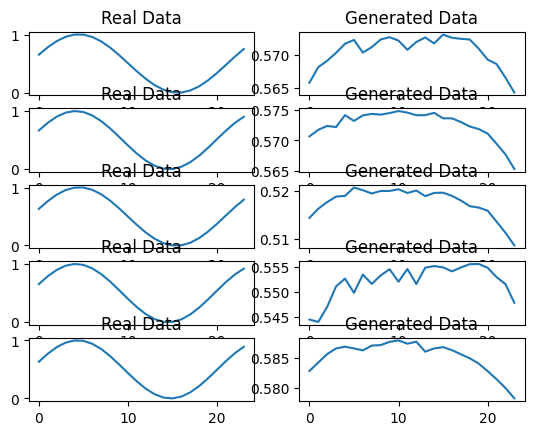

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/1 [00:00<?, ?it/s]

Val Batch:   0%|          | 0/1 [00:00<?, ?it/s]

In [121]:
timegan.train(train_dataset, val_dataset, epochs = 100, optimizer = optimizer)

In [122]:
timegan.test(test_dataset)

Testing:   0%|          | 0/1 [00:00<?, ?it/s]

Test gen_enc_rec_loss: -50.0221, Test disc_loss: -0.0651


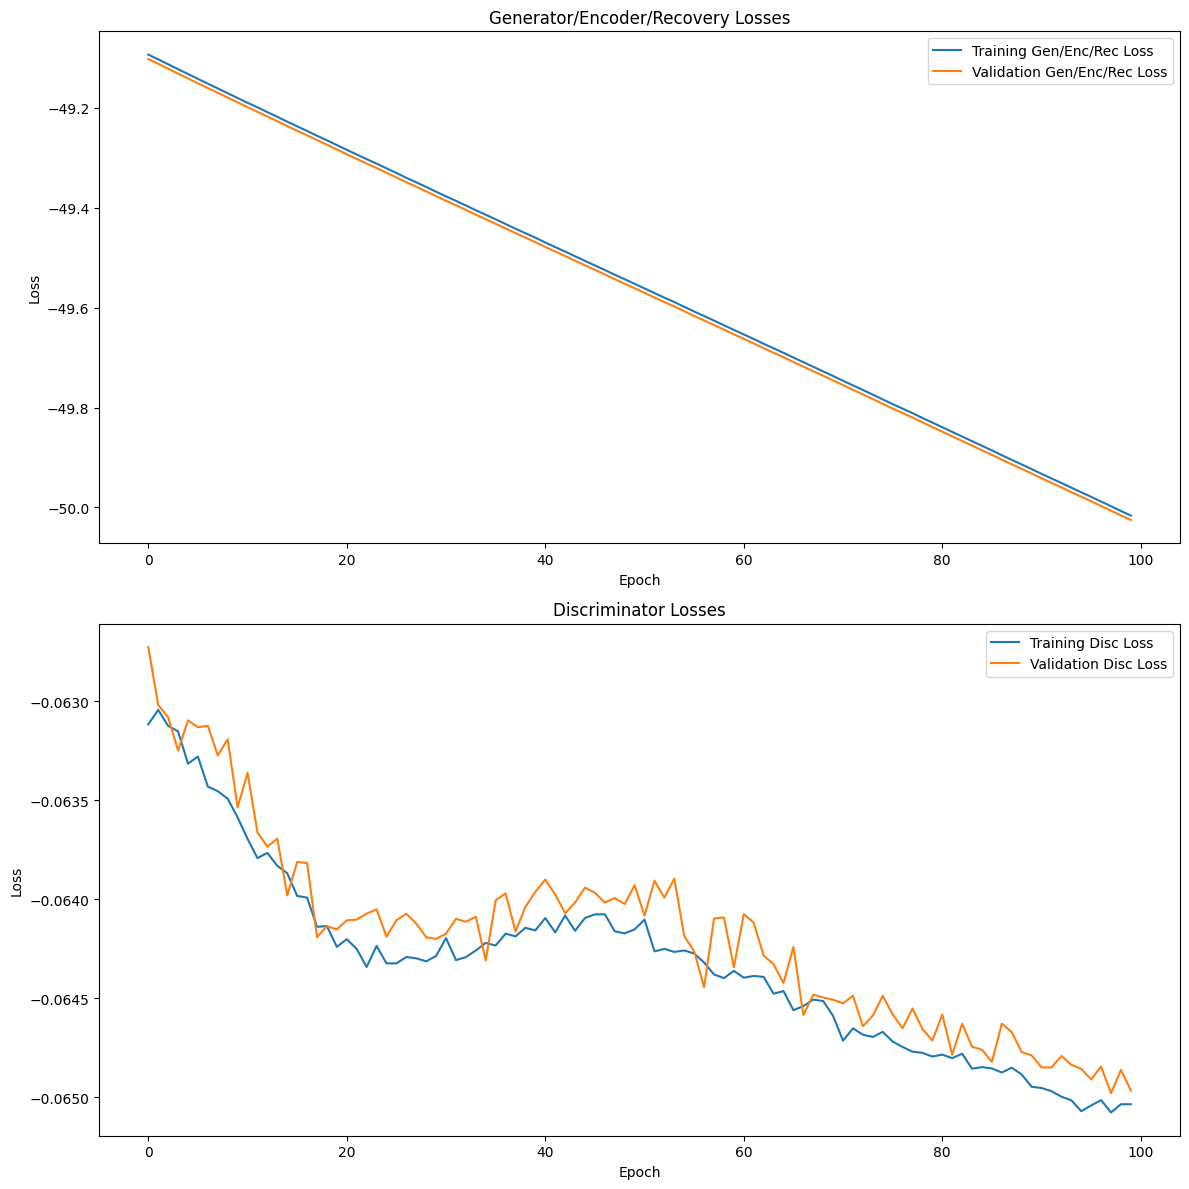

In [123]:
timegan.plot_losses()

# Vizualizations

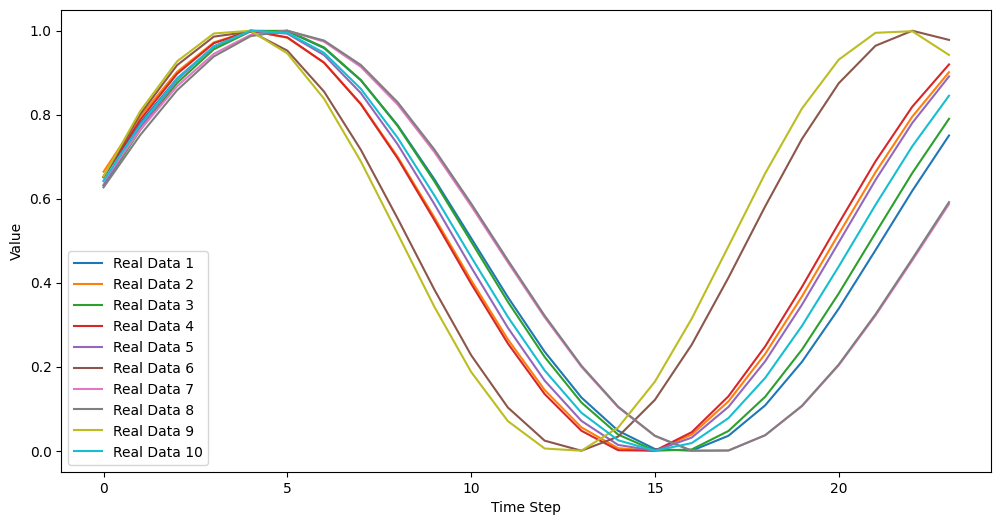

In [105]:
plt.figure(figsize=(12, 6))
for i in range(10):  # adjust as needed
    plt.plot(real_data[i], label=f'Real Data {i+1}')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.show()

In [108]:
# Generate noise for the generator
z = tf.random.normal(shape=(1, seq_len, hidden_dim))

# Generate samples
generated_samples = timegan.generator(z)

# Convert tensor to numpy for visualization
generated_samples = generated_samples.numpy()

In [ ]:
# Determine the number of samples to plot (either in real_data or generated_samples)
num_samples = min(len(real_data), len(generated_samples), 5)

# Select a few random samples within the range
indices = np.random.randint(0, num_samples, num_samples)

# Plot the real samples
plt.figure(figsize=(20, 12))
for i in range(num_samples):
    plt.subplot(num_samples, 2, i * 2 + 1)
    plt.plot(real_data[indices[i]])
    plt.title(f"Real sample {i+1}")

# Plot the generated samples
for i in range(num_samples):
    plt.subplot(num_samples, 2, i * 2 + 2)
    plt.plot(generated_samples[indices[i]])
    plt.title(f"Generated sample {i+1}")

plt.tight_layout()
plt.show()

# checkpointing

## SAVE

In [115]:
# Save the weights of the model
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=timegan)
checkpoint.save('./checkpoints/my_checkpoint')

# To restore the model, you would first create a new model and an optimizer:
new_timegan = TimeGAN(seq_len, n_features, hidden_dim, num_heads, batch_size)
new_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

# Then create a new checkpoint object:
new_checkpoint = tf.train.Checkpoint(optimizer=new_optimizer, model=new_timegan)

# Finally, restore the weights from the checkpoint:
new_checkpoint.restore(tf.train.latest_checkpoint('./checkpoints'))

## LOAD

In [ ]:
# Create a new model and optimizer:
new_timegan = TimeGAN(seq_len, n_features, hidden_dim, num_heads, batch_size)
new_optimizer = optimizer

# Create a new checkpoint object:
new_checkpoint = tf.train.Checkpoint(optimizer=new_optimizer, model=new_timegan)

# Restore the weights from the checkpoint:
new_checkpoint.restore(tf.train.latest_checkpoint('./checkpoints'))

# Compile the model
new_timegan.compile(new_optimizer, wasserstein_loss, gradient_penalty_weight)

# Continue training (just test)
additional_epochs = 1

new_timegan.train(train_dataset, val_dataset, epochs=additional_epochs, optimizer=optimizer)

In [101]:
timegan = new_timegan

In [ ]:
combined_data = np.concatenate([real_data, synthetic_data])
labels = np.concatenate([np.ones(len(real_data)), np.zeros(len(synthetic_data))])

# Split your data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(combined_data, labels, test_size=0.2)

# Train a classifier on your data
classifier = SomeClassifier()  # Replace with your chosen classifier
classifier.fit(train_data, train_labels)

# Compute the score
discriminative_score = classifier.score(test_data, test_labels)